<a href="https://colab.research.google.com/github/danielolusipe/computer_vision/blob/main/Paddy_disease_classification_using_efficientnetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting data

In [1]:
# Importing tensorflow
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
# Uploading .json files
from google.colab import files
files.upload()

In [3]:
# Creating a kaggle folder
! mkdir ~/.kaggle

# Copying the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

# Permission for the json file to act
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Listing out all competition datasets in kaggle
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         47           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         75           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        610           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        102           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1144           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13274           False  
house-pr

In [5]:
# Downloading data from kaggle
! kaggle competitions download -c paddy-disease-classification

100% 1.01G/1.02G [00:10<00:00, 157MB/s]
100% 1.02G/1.02G [00:10<00:00, 108MB/s]


In [ ]:
# Unzipping downloaded data
! unzip paddy-disease-classification.zip

### Preprocessing and becoming one with the data

#### Loading in images from directory

In [7]:
# Setting up paths to directories
train_dir="train_images"
test_dir="test_images"

In [8]:
# Checking the number of images in the training image directory
import os

for dirpath,dirnames,filenames in os.walk("train_images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 10 directories and 0 images in train_images.
There are 0 directories and 620 images in train_images/downy_mildew.
There are 0 directories and 965 images in train_images/brown_spot.
There are 0 directories and 1442 images in train_images/dead_heart.
There are 0 directories and 479 images in train_images/bacterial_leaf_blight.
There are 0 directories and 1738 images in train_images/blast.
There are 0 directories and 1088 images in train_images/tungro.
There are 0 directories and 337 images in train_images/bacterial_panicle_blight.
There are 0 directories and 380 images in train_images/bacterial_leaf_streak.
There are 0 directories and 1764 images in train_images/normal.
There are 0 directories and 1594 images in train_images/hispa.


In [9]:
# Loading in training data into batches from directory and spliting it into training and validation set
IMG_SIZE=(224,224)
train_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       subset="training")

valid_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       subset="validation")

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [10]:
# Getting class_names
class_names=train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


#### Visualizing training images

In [11]:
# Creating a function to visualize random images from training data
# Importing matplotlib library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(target_dir):
  plt.figure(figsize=(8,8))
  for i in range(4):
    plt.subplot(2,2,i+1)
    target_class=random.choice(class_names)
    target_folder=target_dir+"/"+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    print(random_image)
    target_image=target_dir+"/"+target_class+"/"+random_image[0]

    # Reading in and plotting image using matplotlib
    img=mpimg.imread(target_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

['108543.jpg']
['104699.jpg']
['108123.jpg']
['102476.jpg']


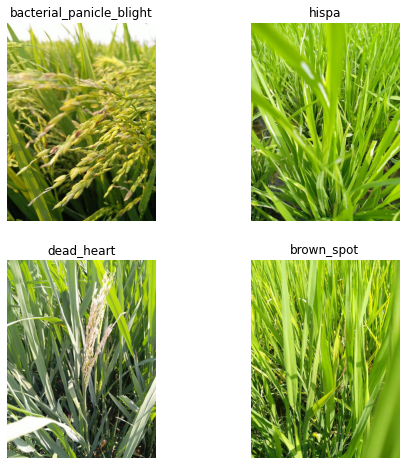

In [12]:
# Visualizing random images from training data
view_random_images("train_images")

### Building model

#### Creating callbacks

In [13]:
# Creating Reduce learning rate callback
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                               factor=0.1,
                                               patience=2, 
                                               min_lr=0.001,
                                               verbose=1)

# Creating ModelCheckpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint/',
                                                    save_weights_only=True,
                                                    save_freq="epoch")

#### Setting up mixed precision

In [14]:
# Importing mixed precision
from tensorflow.keras import mixed_precision

# Setting up mixed precision training in order to make training run faster and use less memory
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

#### Building a feature extraction EfficientNetB4 model and getting model's summary

In [15]:
# Building a non-trainable base model
base_model=tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

# Building a functional model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=base_model(inputs)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x=tf.keras.layers.Dense(128,activation="relu")(x)
x=tf.keras.layers.Dense(64,activation="relu")(x)
x=tf.keras.layers.Dense(len(train_data.class_names))(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32)(x)
model=tf.keras.Model(inputs,outputs)

# Get a summary of model
model.summary()

71696384/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_laye  (None, 1792)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 128)               229504    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650    

#### Compiling and fitting the feature extraction model

In [16]:
# Compiling model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

initial_epoch=20
# Fitting model
history=model.fit(train_data,
                  epochs=initial_epoch,
                  steps_per_epoch=len(train_data),
                  validation_data=valid_data,
                  validation_steps=len(valid_data),
                  callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
261/261 [==============================] - 64s 159ms/step - loss: 1.5013 - accuracy: 0.4891 - val_loss: 1.1681 - val_accuracy: 0.6117 - lr: 0.0010
Epoch 2/20
261/261 [==============================] - 40s 150ms/step - loss: 1.1183 - accuracy: 0.6196 - val_loss: 1.0535 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 3/20
261/261 [==============================] - 39s 148ms/step - loss: 0.9535 - accuracy: 0.6776 - val_loss: 0.8975 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 4/20
261/261 [==============================] - 40s 150ms/step - loss: 0.8236 - accuracy: 0.7209 - val_loss: 0.7716 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 5/20
261/261 [==============================] - 40s 150ms/step - loss: 0.7292 - accuracy: 0.7591 - val_loss: 0.6619 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 6/20
261/261 [==============================] - 40s 150ms/step - loss: 0.6712 - accuracy: 0.7752 - val_loss: 0.5978 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 7/20
261/261 [==============================] 

### Checking the performance of the feature extraction model on validation data

#### Evaluating feature extraction model

In [17]:
# Evaluating feature extraction model
result_feature_extraction=model.evaluate(valid_data)
result_feature_extraction

66/66 [==============================] - 8s 114ms/step - loss: 0.4005 - accuracy: 0.8755


[0.400456041097641, 0.8755406141281128]

#### Plotting train and validation curves

In [18]:
# Creating function to plot training and validation curves seperately
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  # Plotting loss curves
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss curves")
  plt.xlabel("Epochs")
  plt.legend();

  # Plotting accuracy curves
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy curves")
  plt.xlabel("Epochs")
  plt.legend();

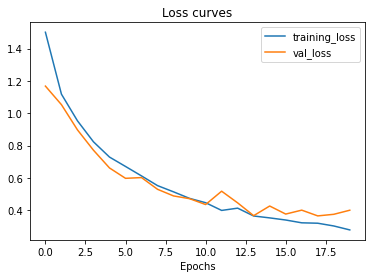

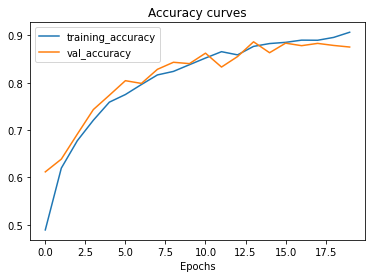

In [19]:
# Plotting model's loss curve
plot_loss_curves(history)

### Improving the performance of feature extraction model by fine-tuning the last 10 layers.

#### Fine-tuning model by setting the base_model to trainable and freezing the all layers except the last 10 layers 

In [20]:
# Setting base_model to trainable
base_model.trainable=True

# Freezing all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
# Checking layers in base_model
for num,layer in enumerate(base_model.layers):
  print(num,layer.name,layer.trainable)

#### Re-compiling and fitting the fine-tuned model

In [22]:
# Re-compiling fine-tuned model with lowered learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics="accuracy")

fine_tune_epoch=initial_epoch+20
# Fitting fine-tuned model
history_last_10_layers=model.fit(train_data,
                                 epochs=fine_tune_epoch,
                                 steps_per_epoch=len(train_data),
                                 validation_data=valid_data,
                                 validation_steps=len(valid_data),
                                 initial_epoch=history.epoch[-1],
                                 callbacks=[reduce_lr])

Epoch 20/40
261/261 [==============================] - 54s 159ms/step - loss: 0.6048 - accuracy: 0.8279 - val_loss: 0.3460 - val_accuracy: 0.8861 - lr: 1.0000e-04
Epoch 21/40
261/261 [==============================] - 40s 150ms/step - loss: 0.2943 - accuracy: 0.9009 - val_loss: 0.2900 - val_accuracy: 0.9154 - lr: 1.0000e-04
Epoch 22/40
261/261 [==============================] - 39s 149ms/step - loss: 0.2134 - accuracy: 0.9296 - val_loss: 0.2794 - val_accuracy: 0.9178 - lr: 1.0000e-04
Epoch 23/40
261/261 [==============================] - 39s 149ms/step - loss: 0.2063 - accuracy: 0.9331 - val_loss: 0.3165 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 24/40
261/261 [==============================] - 39s 149ms/step - loss: 0.1726 - accuracy: 0.9423 - val_loss: 0.2384 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 25/40
261/261 [==============================] - 39s 149ms/step - loss: 0.1482 - accuracy: 0.9497 - val_loss: 0.2167 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 26/40
261/261 [=

### Checking the performance of the fine-tuned model on validation data

#### Evaluating fine-tuned model

In [23]:
# Evaluating fine-tuned model
result_last_10_layers=model.evaluate(valid_data)
result_last_10_layers

66/66 [==============================] - 8s 115ms/step - loss: 0.2156 - accuracy: 0.9447


[0.2155814915895462, 0.9447380900382996]

#### Plotting training and validation loss curves

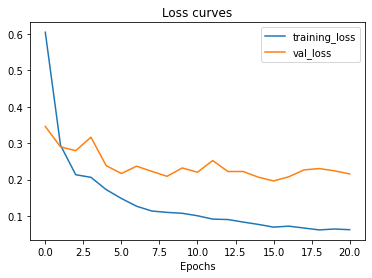

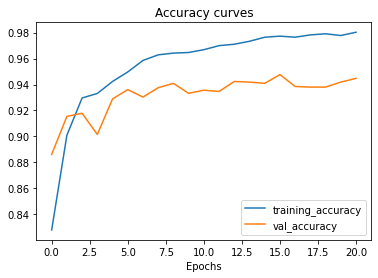

In [24]:
# Plotting loss curves
plot_loss_curves(history_last_10_layers)

### Making further attempt to beat the previously Fine-tuned model performance by fine-tuning last 20 layers

#### Fine-tuning model by setting the base_model to trainable and freezing the all layers except the last 20 layers

In [25]:
# Loading the weights saved earlier
model.load_weights("model_checkpoint/")

In [26]:
# Setting base_model to trainable
base_model.trainable=True

# Freezing all layers except the last 20 layers
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [ ]:
# Checking layers in the base_model
for num,layer in enumerate(base_model.layers):
  print(num,layer.name,layer.trainable)

#### Re-compiling and fitting fine-tuned model(last 20 layers)

In [28]:
# Re-compiling fine-tuned model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics="accuracy")

# Fitting fine-tuned model
history_last_20_layers=model.fit(train_data,
                                 epochs=fine_tune_epoch,
                                 steps_per_epoch=len(train_data),
                                 validation_data=valid_data,
                                 validation_steps=len(valid_data),
                                 initial_epoch=history.epoch[-1],
                                 callbacks=[reduce_lr])

Epoch 20/40
261/261 [==============================] - 56s 165ms/step - loss: 0.5936 - accuracy: 0.8410 - val_loss: 0.3160 - val_accuracy: 0.9068 - lr: 1.0000e-04
Epoch 21/40
261/261 [==============================] - 41s 155ms/step - loss: 0.2685 - accuracy: 0.9102 - val_loss: 0.2691 - val_accuracy: 0.9255 - lr: 1.0000e-04
Epoch 22/40
261/261 [==============================] - 41s 155ms/step - loss: 0.1944 - accuracy: 0.9375 - val_loss: 0.2681 - val_accuracy: 0.9274 - lr: 1.0000e-04
Epoch 23/40
261/261 [==============================] - 41s 154ms/step - loss: 0.1616 - accuracy: 0.9467 - val_loss: 0.2426 - val_accuracy: 0.9284 - lr: 1.0000e-04
Epoch 24/40
261/261 [==============================] - 41s 154ms/step - loss: 0.1364 - accuracy: 0.9536 - val_loss: 0.2336 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 25/40
261/261 [==============================] - 41s 155ms/step - loss: 0.1165 - accuracy: 0.9628 - val_loss: 0.2402 - val_accuracy: 0.9380 - lr: 1.0000e-04
Epoch 26/40
261/261 [=

### Checking the performance of the fine-tuned model (last 20 layers) on validation data

#### Evaluating fine-tuned model

In [29]:
# Evaluating model
result_last_20_layers=model.evaluate(valid_data)
result_last_20_layers

66/66 [==============================] - 8s 114ms/step - loss: 0.2002 - accuracy: 0.9500


[0.2001786082983017, 0.9500240087509155]

#### Plotting training and validation loss curves

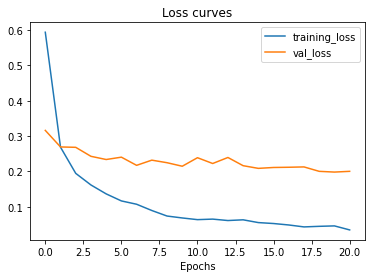

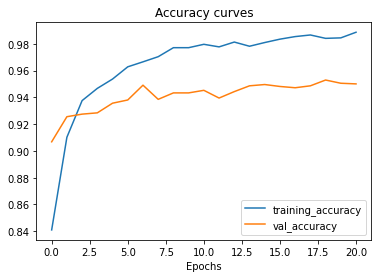

In [30]:
# Plotting model's loss curve
plot_loss_curves(history_last_20_layers)

### Making predictions on test data 

In [31]:
# Loading test data into batches from directory in order to make predictions on it 
test_data=tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                      label_mode=None,
                                                      image_size=IMG_SIZE,
                                                      seed=42,
                                                      shuffle=False)

Found 3469 files belonging to 1 classes.


In [32]:
# Making predictions on test_data
pred_prob=model.predict(test_data,batch_size=32,verbose=1)
pred_prob

109/109 [==============================] - 15s 112ms/step


array([[3.2688121e-07, 2.5002750e-10, 6.6910827e-10, ..., 9.9992478e-01,
        2.8176250e-06, 4.0128623e-07],
       [1.6052243e-09, 4.7152001e-13, 3.6876752e-11, ..., 1.7145337e-06,
        9.9999774e-01, 8.2480955e-09],
       [4.8986512e-06, 4.7379640e-07, 1.6082552e-03, ..., 2.5872269e-04,
        1.9005476e-03, 4.7579284e-05],
       ...,
       [1.3148678e-11, 1.4298523e-12, 4.5797012e-12, ..., 3.9592123e-06,
        9.9998760e-01, 6.9533463e-08],
       [4.0270109e-10, 9.9998593e-01, 2.3390784e-12, ..., 6.8501760e-10,
        9.0981821e-06, 4.1139083e-06],
       [2.3755924e-13, 7.1963712e-20, 2.8317043e-14, ..., 2.1177626e-12,
        1.7346293e-13, 1.7859336e-14]], dtype=float32)

In [33]:
# Getting the highest predicted probabilites
pred=pred_prob.argmax(axis=1)
pred,pred.shape

(array([7, 8, 3, ..., 8, 1, 5]), (3469,))

In [34]:
# Getting class_names for the predicted class
pred_class=[class_names[x] for x in pred]

# Viewing first 10 predictions
pred_class[:10]

['hispa',
 'normal',
 'blast',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

### Making submission on kaggle

#### Adding model predictions column to sample_submission.csv

In [35]:
# Loading the sample_submission.csv into DataFrame and adding prediction columns to the loaded DataFrame 
import pandas as pd
predictions=pd.read_csv("sample_submission.csv")
predictions["label"]=pred_class
predictions.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [36]:
# Exporting pandas Dataframe into csv file
predictions.to_csv('efficientb4_submission.csv',header=True,index = False)
files.download("efficientb4_submission.csv") # Download csv file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Submitting csv file to kaggle
! kaggle competitions submit -c paddy-disease-classification -f efficientb4_submission.csv -m "Paddy Disease Classification"

100% 70.4k/70.4k [00:00<00:00, 146kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification